# Enrichment from FRESCO
5th Apr 2022 

This notebook is for calculating the enrichment from FRESCO by parsing the same `.sdf` file as used for docking.

### Load dockign conformations

In [4]:
from rdkit.Chem import PandasTools

sdfFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/COVID_Moonshot_activity data_2021-03-22_noncovalent_docked.sdf'
df_docking = PandasTools.LoadSDF(
    sdfFile, idName='canonical_CID', smilesName='SMILES', molColName='mol')
print(df_docking)


                                          canonical_CID  \
0     Docking receptor of MPRO-X2908_0A_BOUND(A) > L...   
1                                   EDG-MED-ba1ac7b9-15   
2                                    MAT-POS-9ff17035-2   
3                                    EDJ-MED-8c98ee63-2   
4                                    ALP-POS-64a710fa-1   
...                                                 ...   
2654                                ALP-POS-305f6ec3-52   
2655                                ALP-POS-88a7a97e-23   
2656                                ALP-POS-b0bc6a46-27   
2657                                BRU-THA-92256091-77   
2658                                ALP-POS-ced8ea4d-30   

                                                 SMILES  \
0     CCC(C)C(NC(=O)CNC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)...   
1     C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...   
2     O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...   
3     Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...

In [5]:
from distutils.util import strtobool

df_docking = df_docking.dropna(subset=['acrylamide'])
df_docking['acrylamide'] = df_docking['acrylamide'].apply(
    strtobool).astype(bool)
df_docking['chloroacetamide'] = df_docking['chloroacetamide'].apply(
    strtobool).astype(bool)

df_docking = df_docking.query('~chloroacetamide & ~acrylamide')


parse conformers

In [6]:
moonshot_docking_confomers = []
for mol in df_docking['mol'].values:
    conformer = mol.GetConformer()
    
    data_for_one_molecule = [mol]
    for j, atom in enumerate(mol.GetAtoms()):
        data_for_one_molecule.append([atom.GetSymbol(),
                         conformer.GetPositions()[j]
                         ])
    moonshot_docking_confomers.append(data_for_one_molecule)


Generate pharmacophore dataframe from conformers

In [7]:
from fresco.frag_funcs import return_pcore_dataframe

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

moonshot_pcore_dataframe = return_pcore_dataframe(
    moonshot_docking_confomers, interesting_pcores, hit=False)

100%|██████████| 2538/2538 [00:37<00:00, 67.75it/s]


In [8]:
print(moonshot_pcore_dataframe)


          pcore                                             smiles  mol_id  \
0         Donor  C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...       0   
1         Donor  C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...       0   
2         Donor  C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...       0   
3      Acceptor  C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...       0   
4      Acceptor  C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...       0   
...         ...                                                ...     ...   
21710  Acceptor  O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...    2537   
21711  Aromatic  O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...    2537   
21712  Aromatic  O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...    2537   
21713  Aromatic  O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...    2537   
21714  Aromatic  O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...    2537   

         coord_x   coord_y    coord_z  frag  active  IC50  
0  

Generate pharmacophore 2-body distribution

In [9]:
from fresco.frag_funcs import get_pair_distances
from itertools import product

moonshot_pair_distributions = [None]*len(set(moonshot_pcore_dataframe['mol_id']))
for j, i in tqdm(enumerate(set(moonshot_pcore_dataframe['mol_id'])), total=len(moonshot_pair_distributions)):
    pcore_pair_distribution = {}

    for pcore_pair in product(interesting_pcores, repeat=2):
        core_a, core_b = pcore_pair
        combo = core_a+'-'+core_b
        pcore_pair_distribution[combo] = get_pair_distances(
            moonshot_pcore_dataframe[moonshot_pcore_dataframe['mol_id'] == i], core_a, core_b, frag=False, active=None)
    moonshot_pair_distributions[j] = pcore_pair_distribution


100%|██████████| 2538/2538 [00:43<00:00, 58.24it/s]


Load fragment KDEs

In [10]:
import pickle

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/pickles/'
kde_mpro = 'kde_dict_spl_mpro.pickle'
kde_dict = pickle.load(open(pickle_dir+kde_mpro, 'rb'))


Score moonshot mols with KDEs

In [11]:
import numpy as np
from fresco.frag_funcs import score_dist

pcore_combinations = ['Donor-Aromatic',
                      'Donor-Acceptor',
                      'Aromatic-Aromatic',
                      'Donor-Donor',
                      'Aromatic-Acceptor',
                      'Acceptor-Acceptor']

moonshot_scores = {}
df_docking['mean_frag_score'] = -100.0
for i, pair_dist in enumerate(moonshot_pair_distributions):
    score_df_for_this_molecule = pd.DataFrame(columns=pcore_combinations)
    for pcore_combination in pcore_combinations:
        kde_for_this_combination = kde_dict[pcore_combination]
        pcore_dist = pair_dist[pcore_combination][0].reshape(
            -1, 1)
        pcore_score = score_dist(kde_for_this_combination, pcore_dist)
        score_df_for_this_molecule.at[0, pcore_combination] = pcore_score

    scores = score_df_for_this_molecule[pcore_combinations].to_numpy().astype(
        float)
    scores[np.isnan(scores)] = -100
    processed_score_for_this_molecule = np.nanmean(scores)
    df_docking.at[i, 'mean_frag_score'] = processed_score_for_this_molecule


Average fragment scores over conformers

In [12]:
df_docking.f_avg_IC50 = df_docking.f_avg_IC50.astype(float)
df_docking['Chemgauss4 Score'] = df_docking['Chemgauss4 Score'].astype(float)

columns_to_keep = ['canonical_CID', 'Chemgauss4 Score', 'f_avg_IC50', 'mean_frag_score']
df_docking = df_docking[columns_to_keep]
df_docking_grouped = df_docking.groupby(by=df_docking.canonical_CID).mean()

df_docking_grouped['hit'] = df_docking_grouped['f_avg_IC50'] < 5
print(df_docking_grouped[['hit', 'f_avg_IC50', 'Chemgauss4 Score', 'mean_frag_score']])


                       hit  f_avg_IC50  mean_frag_score
canonical_CID                                          
AAR-POS-0daf6b7e-23  False         NaN        -4.103888
AAR-POS-5507155c-1   False     99.5000        -3.116271
AAR-POS-8a4e0f60-1   False         NaN        -3.203560
AAR-POS-8a4e0f60-10  False         NaN        -2.887218
AAR-POS-8a4e0f60-2   False         NaN        -2.885707
...                    ...         ...              ...
WIL-MOD-03b86a88-2   False     19.0909        -3.490884
WIL-MOD-03b86a88-4   False     15.9534        -2.909079
WIL-MOD-03b86a88-5   False     21.7972        -3.048949
WIL-MOD-03b86a88-6   False     11.2566        -3.073355
WIL-UNI-2e73223c-4   False     99.5000        -3.024804

[1585 rows x 3 columns]


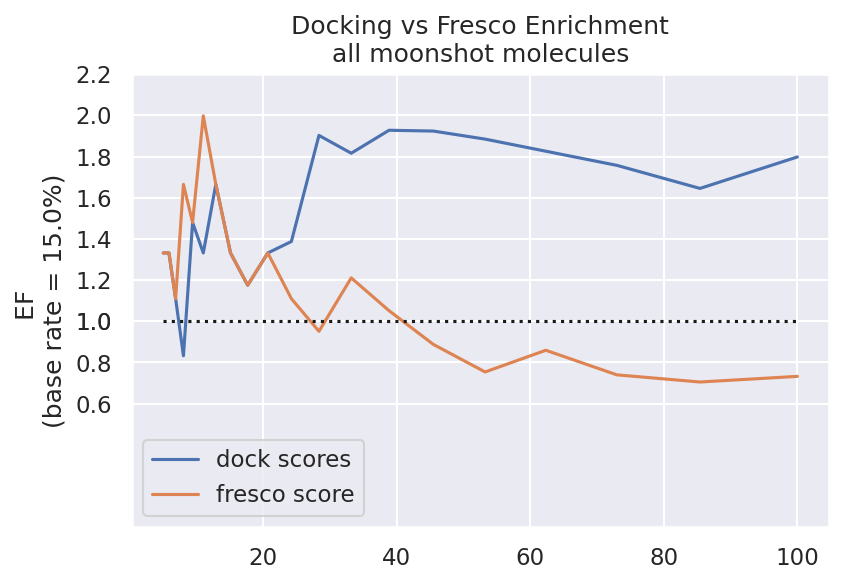

In [23]:
import numpy as np
from fresco.frag_funcs import calculate_enrichment_for_df
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi": 150})


def plot_enrichment_docking_vs_fresco(df_to_plot, title='Not Specified!'):
    n_list = np.logspace(start=np.log10(5), stop=2, num=20)
    EF_docking = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
    EF_fresco = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='mean_frag_score', ascending=False) for n in n_list]
    orig_prop = len(
        df_to_plot[df_to_plot['hit']])/len(df_to_plot)
    
    plt.plot(n_list, EF_docking, label='dock scores')
    plt.plot(n_list, EF_fresco, label='fresco score')
    
    plt.plot(n_list, np.ones_like(n_list), 'k:')
    plt.legend()
    plt.title(f'Docking vs Fresco Enrichment\n{title}')
    plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    extraticks = [1]
    plt.yticks(list(plt.yticks()[0]) + extraticks)
    plt.ylim(bottom=0)


plot_enrichment_docking_vs_fresco(df_docking_grouped,
                title='all moonshot molecules')


Getting submission dates

In [15]:
dateFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/20220122_moonshot_submissions_data_for_alpha.csv'
df_date = pd.read_csv(dateFile)

def remove_suffix(id):
    id_separated = id.split('-')[:-1]
    new_id = '-'.join(id_separated)
    return new_id


df_docking_grouped['canonical_CID'] = df_docking_grouped.index
df_docking_grouped['submission_id'] = df_docking_grouped['canonical_CID'].apply(remove_suffix)
df_merged = df_docking_grouped.merge(df_date, on='submission_id')



Enrichment against time

In [29]:
from ipywidgets import interact
from scipy.stats import spearmanr as spear


def plot_enrichment_against_time(year, month, ic50_threshold):
    day = '01'
    date_to_filter = int(f'{year}{month}{day}')
    df_filtered_by_date = df_merged.query('date < @date_to_filter')
    df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold
    rho = spear(df_filtered_by_date['Chemgauss4 Score'].values, df_filtered_by_date['mean_frag_score'].values)[0]

    print(df_filtered_by_date['hit'].value_counts())
    plot_enrichment_docking_vs_fresco(df_filtered_by_date,
                    title=f'IC50 < {ic50_threshold}uM, rho = {rho:.2f}\nbefore {day}-{month}-{year} (n={len(df_filtered_by_date)})')
    return


years_to_choose_from = ['2021', '2020']
months_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 13)]

interact(plot_enrichment_against_time,
         year=years_to_choose_from, month=months_to_choose_from, ic50_threshold=(0.0, 100.0))


interactive(children=(Dropdown(description='year', options=('2021', '2020'), value='2021'), Dropdown(descripti…

<function __main__.plot_enrichment_against_time(year, month, ic50_threshold)>

# MPro EF curves

In [ ]:
# load ligands 
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

hits = pickle.load(open(data_dir+'/hits_new.pickle', 'rb'))   
threshold = 5 # IC50 threshold for activity 

# hits = pickle.load(open('hits_may.list', 'rb')) 
#   
hitpcore_df = frag_funcs.return_pcore_dataframe(hits, interesting_pcores, hit=True, threshold=threshold)

smiles_list = [None]*len(set(hitpcore_df['mol_id']))  
activity_list = [None]*len(set(hitpcore_df['mol_id']))
IC50_list = [None]*len(set(hitpcore_df['mol_id']))

for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles']
    activity_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active']
    IC50_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['IC50']

xray_hit_pairs = pickle.load(open(data_dir+'/hit_pairs.pickle', 'rb'))

xray_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
xray_df['smiles'] = smiles_list
xray_df['hit'] = activity_list

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
print('base rate = {:.1f}%'.format(xray_prop*100))
assert len(hits) == len(xray_hit_pairs)

## Generate pharmacophore distribution for moonshot molecules

In [ ]:
hit_mols = [None]*len(hits)
for i,hit in tqdm(enumerate(hits), total=len(hits)):
    try:
        mol = MolFromSmiles(MolToSmiles(hit[0]))

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        mol_data.append(hit[-1])
        hit_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue
    
hitpcore_df = frag_funcs.return_pcore_dataframe(hit_mols, interesting_pcores, hit=True, threshold=threshold)

fresh_hit_pairs = [None]*len(set(hitpcore_df['mol_id']))
for j,i in tqdm(enumerate(set(hitpcore_df['mol_id'])), total=len(fresh_hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo], _ = frag_funcs.get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    fresh_hit_pairs[j] = hit_pair_individual

### All moonshot molecules

In [ ]:
df = pd.read_csv('../data/activity_data.csv')
df = df[(df['acrylamide']==False) & (df['chloroacetamide']==False)]
df.reset_index(inplace=True)

all_mols = [None]*len(df)
for i,row in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = MolFromSmiles(row['SMILES'])

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        # NaNs
        mol_data.append(row['f_avg_IC50'])
        all_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue
all_mols = [mol for mol in all_mols if mol is not None]

threshold = 5 # IC50 threshold for activity 
hitpcore_df = frag_funcs.return_pcore_dataframe(all_mols, interesting_pcores, hit=True, threshold=threshold)

fresh_hit_pairs = [None]*len(set(hitpcore_df['mol_id']))
for j,i in tqdm(enumerate(set(hitpcore_df['mol_id'])), total=len(fresh_hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo], _ = frag_funcs.get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    fresh_hit_pairs[j] = hit_pair_individual

smiles_list = []
activity_list = []
for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles'])
    activity_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active'])
    
fresh_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
fresh_df['smiles'] = smiles_list
fresh_df['hit'] = activity_list

fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)
print('base rate = {:.1f}%'.format(fresh_prop*100))

In [ ]:
# pd.options.mode.chained_assignment = 'raise'
def score_dist(kde, dist):
    if len(dist): # non-zero length

        # log-prob (larger = higher prob)
        # score using scipy spline!
        score = kde(dist.reshape(-1, 1))

        # score = kde.score_samples(dist.reshape(-1,1))
        score = np.mean(score)
        
        # mask = score<-6

        # score = np.where(mask, np.nan, score)
        # score = np.nanmean(score)

        # score = np.exp(np.where(mask, np.nan, score))
        # df.at[i, combo] = np.nansum(score)
        return score
    else:
        return np.nan

# weigh & score pharmacophores

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

# kde_dict_opt = pickle.load(open('pickles/kde_dict_opt_mpro.pickle', 'rb'))
kde_dict_opt = new_kdes

pairs = important+unimportant

num_weights = np.empty((len(pairs)))

for j,combo in enumerate(pairs):
    core_a,core_b = combo.split('-')
    num_weights[j] = len(frag_pair_distance_dict[combo])
    kde = kde_dict_opt[combo]

    # rand_kdes = []
    # for n in range(n_rand):
    #     kdepy_model = FFTKDE(kernel='gaussian', bw='ISJ').fit(
    #     rand_pair_dicts[n][combo])
    #     kdepy_bw = kdepy_model.bw

    #     kde_new = KernelDensity(
    #         kernel='gaussian', bandwidth=kdepy_bw, rtol=1e-4).fit(rand_pair_dicts[n][combo].reshape(-1, 1))
    #     rand_kdes.append(kde_new)

    for i in range(len(xray_hit_pairs)):
        dist = xray_hit_pairs[i][combo][0]
        
        xray_df.at[i, combo] = score_dist(kde, dist)

        # xray_df.at[i, combo] = n_rand*score_dist(kde, dist)
        # for n in range(n_rand):
        #     xray_df.at[i, combo] -= score_dist(rand_kdes[n], dist)

            
    for i in range(len(fresh_hit_pairs)):
        fresh_dist = fresh_hit_pairs[i][combo][0]
        
        fresh_df.at[i, combo] = score_dist(kde, fresh_dist)

        # fresh_df.at[i, combo] = n_rand*score_dist(kde, fresh_dist)
        # for n in range(n_rand):
        #     fresh_df.at[i, combo] -= score_dist(rand_kdes[n], fresh_dist)

    print('Xray: Prop of NaNs for {} = {:.1f}%'.format(combo, 100*len(xray_df[xray_df[combo].isnull()])/len(xray_df)))
    print('Fresh: Prop of NaNs for {} = {:.1f}%'.format(
        combo, 100*len(fresh_df[fresh_df[combo].isnull()])/len(fresh_df)))

# CALCULATE EFs
# num_weights = np.array([0,0,1,0,0,0])

hit_dfs = [xray_df, fresh_df]
for hit_df in hit_dfs:
    hit_df[pairs] = hit_df[pairs].astype(float)

    hit_df['imp_score'] = np.nanmean(hit_df[important].to_numpy(), axis=1)
    hit_df['nonimp_score'] = np.nanmean(hit_df[unimportant].to_numpy(), axis=1)
    hit_df['hit'] = hit_df['hit'].astype('Int64').astype(bool)

    x = hit_df[pairs].to_numpy()
    hit_df['both_score'] = np.nanmean(x, axis=1)
    # hit_df['weighed_score'] = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)

# PLOT HISTOGRAMS
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                        dpi=150, constrained_layout=True)
for pair in pairs:
    axs[0].hist(xray_df[xray_df[pair].notnull()][pair].astype(float).values, density=True,
                alpha=0.5, histtype='stepfilled', label=pair)
    axs[1].hist(fresh_df[fresh_df[pair].notnull()][pair].astype(float).values, density=True,
             alpha=0.5, histtype='stepfilled', label=pair)
             
axs[0].set_title('Xray scores')
axs[1].set_title('RDKit scores')
axs[0].set_xlim(left=-10)
axs[1].set_xlim(left=-10)
axs[1].legend()
fig.suptitle('Distribution of 2-body scores')
plt.show()

n_list = np.logspace(start=1, stop=2, num=20) # only check from 10 to 100

xray_EF = [enrichment(xray_df, n=int(n), score='both_score') for n in n_list]
xray_EF_imp = [enrichment(xray_df, n=int(n), score='imp_score') for n in n_list]
xray_EF_nonimp = [enrichment(xray_df, n=int(n), score='nonimp_score') for n in n_list]
# xray_EF_weighed = [enrichment(xray_df, n=int(n),  score='weighed_score') for n in n_list]

fresh_EF = [enrichment(fresh_df, n=int(n), score='both_score') for n in n_list]
fresh_EF_imp = [enrichment(fresh_df, n=int(n), score='imp_score') for n in n_list]
fresh_EF_nonimp = [enrichment(fresh_df, n=int(n), score='nonimp_score') for n in n_list]
# fresh_EF_weighed = [enrichment(fresh_df, n=int(n),  score='weighed_score') for n in n_list]

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)

# PLOTTING

# fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, dpi=200, constrained_layout=True)
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, dpi=150, constrained_layout=True)
axs[0].plot(n_list, xray_EF_imp, '-', label='Important',
            color='#7a5195', alpha=0.7)
axs[0].plot(n_list, xray_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[0].plot(n_list, xray_EF, '-', label='All', color='#003f5c', alpha=0.7)
# axs[0].plot(n_list, xray_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

axs[1].plot(n_list, fresh_EF_imp, '-', label='Important', color='#7a5195', alpha=0.7)
axs[1].plot(n_list, fresh_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[1].plot(n_list, fresh_EF, '-', label='All', color='#003f5c', alpha=0.7)
# axs[1].plot(n_list, fresh_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

fig.suptitle(r'2-Body $EF(n)$ (IC50 < {}$\mu$M) - moonshot molecules only'.format(threshold))
axs[0].set_title('X-ray confs (n={})'.format(len(xray_df)))
axs[1].set_title('RDKit confs (n={})'.format(len(fresh_df)))
# plt.xscale('log')
plt.legend(prop={'size': 8})

for ax in axs:
    ax.plot(n_list, np.ones_like(n_list), 'k:')

    # extraticks = [1]
    # ax.set_yticks(list(plt.yticks()[0]) + extraticks)
    # ax.set_ylim(bottom=0)
    ax.set_xlabel('n')
axs[0].set_ylabel('EF \n(base rate = {:.1f}%)'.format(xray_prop*100))
axs[1].set_ylabel('EF \n(base rate = {:.1f}%)'.format(fresh_prop*100))
plt.show()


### Comparison vs ZINC

In [ ]:
### Generate random ZINC conformer 26/02/2021
import random 

n_zinc = 5000

# zinc_smi = pd.read_csv(zinc_dir+'/zinc_subset.smi', delim_whitespace=True)['smiles'].values
zinc_smi = pd.read_csv('/rds-d2/user/wjm41/hpc-work/datasets/ZINC/zinc_250k.csv')['smiles'].values

rand_smi = random.sample(list(zinc_smi), k=n_zinc)

zinc_mols = [None]*len(rand_smi)
for i,smi in tqdm(enumerate(rand_smi), total=len(rand_smi)):
    try:
        mol = MolFromSmiles(smi)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        zinc_mols[i] = mol_data
    except:
        print(str(i)+' failed')
        continue
assert len(zinc_mols) == n_zinc
print('Number of sampled molecules :{}'.format(len(zinc_mols)))

zinc_mols = [ i for i in zinc_mols if i]

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Donor-Acceptor',
               'Acceptor-Acceptor']

pairs = important+unimportant
zinccore_df = frag_funcs.return_pcore_dataframe(zinc_mols, interesting_pcores, hit=False)

zinc_pairs = [None]*len(set(zinccore_df['mol_id']))
for j,i in tqdm(enumerate(set(zinccore_df['mol_id'])), total=len(zinc_pairs)):
    zinc_pair_individual = {}
    
    for combo in pairs:
        core_a,core_b = combo.split('-')
        zinc_pair_individual[combo], _ = frag_funcs.get_pair_distances(zinccore_df[zinccore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    zinc_pairs[j] = zinc_pair_individual

zinc_smi = []
zinc_activity = []

for i in tqdm(set(zinccore_df['mol_id'])):
    zinc_smi.append(zinccore_df[zinccore_df['mol_id']==i].iloc[0]['smiles'])
    zinc_activity.append(False)
    
assert len(zinc_smi) == len(zinc_pairs)

In [ ]:
# weigh & score pharmacophores

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

# kde_dict_opt = pickle.load(open('pickles/kde_dict_opt_mpro.pickle', 'rb'))
kde_dict_opt = new_kdes

pairs = important+unimportant

zinc_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
zinc_df['smiles'] = zinc_smi
zinc_df['hit'] = zinc_activity

num_weights = np.empty((len(pairs)))

for j,combo in enumerate(pairs):
    core_a,core_b = combo.split('-')
    num_weights[j] = len(frag_pair_distance_dict[combo])
    kde = kde_dict_opt[combo]

    # w = p_dict[combo]

    for i in range(len(fresh_hit_pairs)):
        fresh_dist = fresh_hit_pairs[i][combo][0]

        fresh_df.at[i, combo] = score_dist(kde, fresh_dist)#/w

    for i in range(len(zinc_pairs)):
        zinc_dist = zinc_pairs[i][combo][0]

        zinc_df.at[i, combo] = score_dist(kde, zinc_dist)#/w

# CALCULATE EFs
# num_weights = np.array([0,0,1,0,0,0])
# num_weights = d_median

fresh_df['df'] = 'Moonshot'
zinc_df['df'] = 'ZINC'
total_df = pd.concat([fresh_df, zinc_df]).reset_index()

total_df[pairs] = total_df[pairs].astype(float)
x = total_df[important].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['imp_score'] = np.nanmean(x, axis=1)
x = total_df[unimportant].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['nonimp_score'] = np.nanmean(x, axis=1)
# total_df['imp_score'] = np.ma.mean(total_df[important].to_numpy(), axis=1)
# total_df['nonimp_score'] = np.ma.mean(total_df[unimportant].to_numpy(), axis=1)
total_df['hit'] = total_df['hit'].astype('Int64').astype(bool)

x = total_df[pairs].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['both_score'] = np.nanmean(
    x, axis=1)


# total_df['both_score'] = np.nanmin(x, axis=1)
# total_df['both_score'] = np.ma.sum(total_df[pairs].to_numpy(na_value=False), axis=1)
# scores = total_df[pairs].to_numpy().astype(float)
# total_df['weighed_score'] = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)
# print(total_df.head())

# fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
#                         dpi=200, constrained_layout=True)
# for pair in pairs:
#     axs[0].hist(fresh_df[fresh_df[pair].notnull()][pair].astype(float).values, density=True,
#                 alpha=0.5, histtype='stepfilled', label=pair)
#     axs[1].hist(zinc_df[zinc_df[pair].notnull()][pair].astype(float).values, density=True,
#                 alpha=0.5, histtype='stepfilled', label=pair)

# plt.legend(loc='upper left')
# axs[0].set_title('Moonshot scores')
# axs[1].set_title('ZINC scores')
# axs[0].set_xlim(left=-10)
# axs[1].set_xlim(left=-10)
# fig.suptitle('Distribution of 2-body scores')
# plt.show()

# sns.displot(total_df[total_df['both_score'].notnull()],
#             x='both_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['imp_score'].notnull()], x='imp_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['nonimp_score'].notnull()], x='nonimp_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['weighed_score'].notnull()], x='weighed_score', hue='df', stat='density')
# plt.xlim(left=-10)

# plt.hist(total_df['both_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='both_score')
# plt.hist(total_df['imp_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='imp_score')
# plt.hist(total_df['nonimp_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='nonimp_score')
# plt.hist(total_df['weighed_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='weighed_score')

# n_list = np.logspace(start=np.log10(5), stop=2, num=20) # only check top 100
n_list = np.linspace(start=5, stop=100, num=100)

fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
fresh_EF_imp = [enrichment(total_df, n=int(n), score='imp_score') for n in n_list]
fresh_EF_nonimp = [enrichment(total_df, n=int(n), score='nonimp_score') for n in n_list]
# fresh_EF_weighed = [enrichment(total_df, n=int(n),  score='weighed_score') for n in n_list]

orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, dpi=200, constrained_layout=True)

ax.plot(n_list, fresh_EF_imp, '-', label='Important', color='#7a5195', alpha=0.7)
ax.plot(n_list, fresh_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
ax.plot(n_list, fresh_EF, '-', label='All', color='#003f5c', alpha=0.7)
# ax.plot(n_list, fresh_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

fig.suptitle(r'2-Body $EF$ (IC50 < {}$\mu$M)- moonshot + ZINC (n={})'.format(threshold, n_zinc))
ax.set_title('RDKit confs')
# plt.xscale('log')
plt.legend(prop={'size': 8})


ax.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()


In [ ]:
sns.set(font='Free Mono')
sns.set_style('white')
orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, dpi=200, constrained_layout=True)
fig.suptitle(r'Enrichment (IC50 < {}$\mu$M)'.format(threshold))
# plt.xscale('log')
# plt.legend(prop={'size': 8})

n_list = np.linspace(start=3, stop=100, num=100)  # only check top 100
fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
ax.plot(n_list, fresh_EF, '-', color='#1E85FC')
ax.plot([0, 100], [1, 1], 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0, top=10.1)
ax.set_xlim(left=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
sns.despine()
plt.show()


In [ ]:
n = 1 

num_weights = np.array([1,1,1,0,0,0])
imp_score = np.nanmean(hit_df[important].to_numpy()[n], axis=0)

x = hit_df[pairs].to_numpy()[n].astype(float)
weigh_score = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)
print(np.where(np.isnan(x), 0, 1).dot(num_weights))

print(imp_score)
print(weigh_score)